In [1]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5


In [3]:
print(os.getcwd())

/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src


In [4]:
param_file = '../../../cellbgnet/utils/reference_files/reference_Axel.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)


In [5]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']


In [6]:
psf_size = 41
xextent = [-0.5, 127.5]
yextent = [-0.5, 127.5]
zextent = [-400, 400]
scale = torch.tensor([(xextent[1] - xextent[0]),
                      (yextent[1] - yextent[0]),
                      (zextent[1] - zextent[0])])
shift = torch.tensor([xextent[0], yextent[0], zextent[0]])



In [7]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 63.5], yextent=[-0.5, 63.5], img_shape=[64, 64], device='cuda', 
roi_size=None, roi_auto_center=None, normalize=True)


INITIATING CUDA IMPLEMENTATION


In [8]:
epochs = 40
batch_size = 128
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [10]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

In [11]:
def create_psf_batch(size=64, batch_size=128):
    xyz = torch.normal(float(size/2), float(size/4), (batch_size,3))
    xyz[:, 2] = 0.0
    xyz = xyz.view(1, -1, 3)
    photon_scale = 100
    #photons = torch.rand((xyz.shape[1], 1))*photon_scale
    photons = torch.ones((xyz.shape[1], 1))*photon_scale
    frames = torch.cat([psf.forward(xyz[:,i,...], photons[i]) for i in range(xyz.shape[1])])
    max_val = torch.max(frames)
    frames = frames/max_val
    frames = frames.view(frames.shape[0],1,frames.shape[1], frames.shape[2])
    return frames, xyz, photons


In [12]:
frames,_, _ = create_psf_batch()

In [13]:
def create_batch(size=28, batch_size=64):
    batch = torch.zeros([batch_size,1,size,size])
    xys = torch.tensor([[0], [0]])
    xs = torch.randint(0, size, (batch_size,))
    ys = torch.randint(0, size,  (batch_size,))
    xys = torch.concatenate([xs.view(-1,1), ys.view(-1,1)], dim=1)
    batch[torch.arange(batch.shape[0]),0, xs, ys] = 1
    return batch, xys

In [25]:
model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_2.pt")

#model = model_conv.VAE(zDim=2, featureDim=32*56*56, imsize=(64,64)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')


In [26]:
#model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_1.pt")


In [27]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD*2, BCE, KLD

In [28]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i in range((64*64)//batch_size):
        data = create_psf_batch()
        data, xyz, _ = data
        data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss, BCE, KLD = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/(64*64)
    return train_loss

In [29]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_BCE = 0.0
    running_KLD = 0.0
    with torch.no_grad():
        for i in range((64*64)//batch_size):
            data = create_psf_batch()
            data, xys, _ = data
            data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss, BCE, KLD = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            running_BCE += BCE.item()
            running_KLD += KLD.item()
            # save the last batch input and output of every epoch
            if ((64*64)//batch_size - 1) and (epoch % 100 == 0):
                #plt.imshow(data.view(batch_size, 1, 64, 64)[0,0,...].cpu().detach().numpy(), cmap='gray')
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                                  reconstruction.view(batch_size, 1, 64, 64)[:8]))
                save_image(both.cpu(), f"../outputs/conv_out/psf_conv_output{epoch}.png", nrow=num_rows, pad_value=1)

    val_loss = running_loss/(64*64)
    bce_loss_tot = running_BCE/(64*64)
    kld_loss = running_KLD/(64*64)
    return val_loss, mu, xys, bce_loss_tot, kld_loss

In [64]:
train_loss = []
val_loss = []
bce_loss_list = []
kld_loss_list = []
curr = 2147
epochs = 1000
for epoch in range(curr, curr+epochs+1):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, 0)
    val_epoch_loss, mu, xys, bce_loss, kld_loss = validate(model, 0)
    bce_loss_list.append(bce_loss)
    kld_loss_list.append(kld_loss)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"BCE: {bce_loss:.4f}, KLD: {kld_loss:.4f}")


Epoch 1788 of 1000
Train Loss: 135.0946
BCE: 121.5362, KLD: 6.7223
Epoch 1789 of 1000
Train Loss: 134.8808
BCE: 121.8980, KLD: 6.7064
Epoch 1790 of 1000
Train Loss: 135.4431
BCE: 121.2609, KLD: 6.7880
Epoch 1791 of 1000
Train Loss: 135.6046
BCE: 122.2108, KLD: 6.6473
Epoch 1792 of 1000
Train Loss: 134.2347
BCE: 121.8247, KLD: 6.6030
Epoch 1793 of 1000
Train Loss: 135.1878
BCE: 121.5702, KLD: 6.6420
Epoch 1794 of 1000
Train Loss: 134.4491
BCE: 121.5695, KLD: 6.5933
Epoch 1795 of 1000
Train Loss: 134.2729
BCE: 121.1363, KLD: 6.7002
Epoch 1796 of 1000
Train Loss: 135.0389
BCE: 121.6269, KLD: 6.6614
Epoch 1797 of 1000
Train Loss: 134.7219
BCE: 121.2119, KLD: 6.7481
Epoch 1798 of 1000
Train Loss: 134.6250
BCE: 121.4780, KLD: 6.7051
Epoch 1799 of 1000
Train Loss: 134.4161
BCE: 121.4068, KLD: 6.6957
Epoch 1800 of 1000
Train Loss: 133.6327
BCE: 121.2925, KLD: 6.6829
Epoch 1801 of 1000
Train Loss: 135.6922
BCE: 121.8823, KLD: 6.6225
Epoch 1802 of 1000
Train Loss: 135.9716
BCE: 122.2594, KLD: 6.

KeyboardInterrupt: 

In [65]:
torch.save(model, "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_2.pt")
torch.save(model.state_dict(), "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_2_sd.pt")

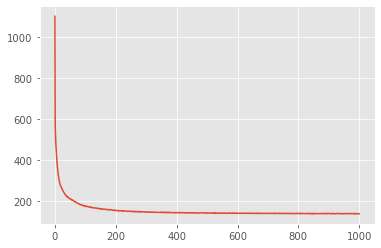

In [20]:
plt.plot(list(range(len(train_loss))), train_loss)


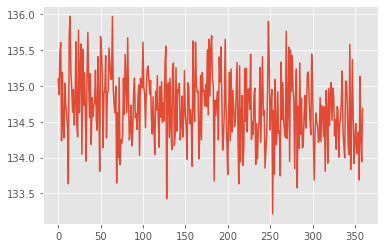

In [66]:
plt.plot(list(range(len(train_loss))), train_loss)


In [19]:
torch.cuda.empty_cache()

In [43]:
all_xys.shape
all_mus.shape

torch.Size([11000, 2])

In [67]:
images, xys, _ = create_psf_batch(batch_size=1000)
model.eval()
images = images.to(device)
reconstruction, mu, logvar = model(images)
all_xys = xys
all_mus = mu
for i in range(10):
    images, xys, _ = create_psf_batch(batch_size=1000)
    model.eval()
    images = images.to(device)
    reconstruction, mu, logvar = model(images)
    del reconstruction
    del images

    all_xys = torch.cat((all_xys, xys), dim=1)
    del xys
    all_mus = torch.cat((all_mus, mu), dim=0)
    del mu


In [68]:
yin = (all_xys[0,:,1]>-1) & (all_xys[0,:,1]<64)
xin = (all_xys[0,:,0]>-1) & (all_xys[0,:,0]<64)
both_in = xin&yin


In [69]:
predicted = all_mus[both_in,0].cpu().detach().numpy()
x = all_xys[0,both_in,1]

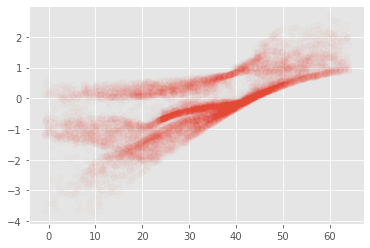

In [70]:
plt.plot(x, predicted, 'o', alpha=0.01)


In [71]:
predicted = all_mus[both_in,1].cpu().detach().numpy()
x = all_xys[0,both_in,0]


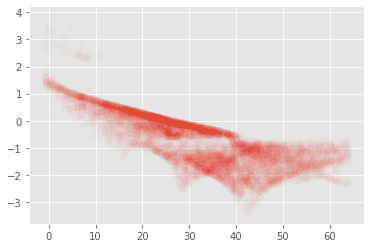

In [72]:
plt.plot(x, predicted, 'o', alpha=0.01)


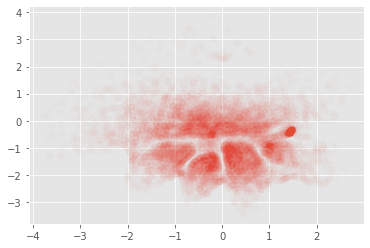

In [73]:
plt.plot(all_mus[:,0].cpu().detach().numpy(), all_mus[:,1].cpu().detach().numpy(), 'o', alpha=0.01)

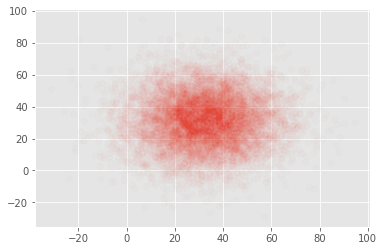

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.plot(all_xys[0,:,0].cpu().detach().numpy(), all_xys[0,:,1].cpu().detach().numpy(), 'o', alpha=0.01)


In [37]:
images.max()

tensor(2.1374, device='cuda:0')

In [ ]:
#both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                    reconstruction.view(batch_size, 1, 64, 64)[:8]))
#save_image(both.cpu(), f"../outputs/psf_output{epoch}.png", nrow=num_rows)


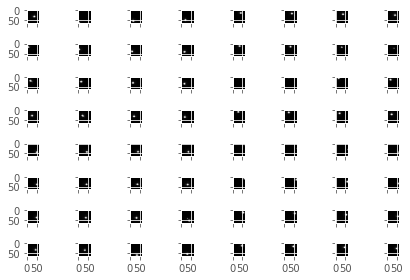

In [144]:
model.eval()
fig, axs = plt.subplots(8,8, sharex=True, sharey=True)
# decoding
fig.tight_layout()
for i in range(-4,4):
    for j in range(-4,4):
        z = torch.tensor([[float(i),float(j)]]).cuda()
        axs[i,j].imshow(reconstruction.view((64, 64)).cpu().detach().numpy(), cmap='gray')

plt.show()


In [137]:
reconstruction.view((64, 64))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0368e-01, 3.2587e-01,
         2.6970e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.7344e-01, 4.9652e-01,
         3.5723e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4673e-01, 8.1915e-01,
         6.0063e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4258e-36, 3.9615e-36,
         4.5398e-36],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4501e-39, 7.5286e-39,
         5.2027e-39],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<ViewBackward0>)

type: module 'torch' has no attribute 'repeat'

In [199]:
mus = torch.cat((torch.arange(-6,7).repeat(13).view(-1,1),torch.arange(-6,7).repeat_interleave(13).view(-1,1)),1)

In [201]:
model.eval()
z = mus.float().cuda()
x = F.relu(model.dec1(z))
reconstruction = torch.sigmoid(model.dec2(x))


In [206]:
save_image(reconstruction.view((13*13, 1, 64,64)).cpu(), f"../outputs/test_values.png", nrow=13, pad_value=1)

In [204]:
reconstruction.shape

torch.Size([169, 4096])

tensor([[-6., -6.],
        [-5., -6.],
        [-4., -6.],
        [-3., -6.],
        [-2., -6.],
        [-1., -6.],
        [ 0., -6.],
        [ 1., -6.],
        [ 2., -6.],
        [ 3., -6.],
        [ 4., -6.],
        [ 5., -6.],
        [ 6., -6.],
        [-6., -5.],
        [-5., -5.],
        [-4., -5.],
        [-3., -5.],
        [-2., -5.],
        [-1., -5.],
        [ 0., -5.],
        [ 1., -5.],
        [ 2., -5.],
        [ 3., -5.],
        [ 4., -5.],
        [ 5., -5.],
        [ 6., -5.],
        [-6., -4.],
        [-5., -4.],
        [-4., -4.],
        [-3., -4.],
        [-2., -4.],
        [-1., -4.],
        [ 0., -4.],
        [ 1., -4.],
        [ 2., -4.],
        [ 3., -4.],
        [ 4., -4.],
        [ 5., -4.],
        [ 6., -4.],
        [-6., -3.],
        [-5., -3.],
        [-4., -3.],
        [-3., -3.],
        [-2., -3.],
        [-1., -3.],
        [ 0., -3.],
        [ 1., -3.],
        [ 2., -3.],
        [ 3., -3.],
        [ 4., -3.],
